在沙盒环境下， gridsearch调优机器学习模型参数

In [2]:
import os,pdb,itertools,copy,datetime,sys,collections
os.environ['ULTRON_DATA'] = 'keim'

In [3]:
import numpy as np
import pandas as pd
import datetime

In [4]:
from ultron.env import *
from ultron.kdutils.kline import date_week_wave
from ultron.kdutils import scaler as scaler_util
from ultron.kdutils.date import week_of_date
from ultron.ump.indicator import nd
from ultron.optimize.model.automodel import AutoModel,EMLFitType
from matplotlib import pyplot as plt

/var/log/ultron/2022-10-10.log


In [5]:
enable_example_env()

2022-10-10 10:27:32,538 - [env.py:107] - ultron - INFO - enable example env will only read /home/kerry/ultron/rom/sandbox/keim


In [6]:
def next_returs_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = np.log(price_tb.shift(-1) / price_tb)
    return_tb = return_tb.replace([np.inf, -np.inf], np.nan)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [7]:
def pre_close_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = price_tb.shift(-1)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [8]:
kl = pd.read_csv(os.path.join(g_project_data, 'market_data.csv'), index_col=0)
kl['trade_date'] = pd.to_datetime(kl['trade_date'])

next_rets = next_returs_impl(
    kl.set_index(['trade_date','code']),'closePrice','nxt1_ret').reset_index()
next_rets['trade_date'] = pd.to_datetime(next_rets['trade_date'])


pre_close = pre_close_impl(
    kl.set_index(['trade_date','code']),'closePrice','pre_close').reset_index()
pre_close['trade_date'] = pd.to_datetime(pre_close['trade_date'])

kl = kl.merge(next_rets, on=['trade_date','code']).merge(
    pre_close, on=['trade_date','code'])
kl['date'] = pd.to_datetime(kl['trade_date']).dt.strftime('%Y%m%d').astype(int)
kl['date_week'] = kl['date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').weekday())
kl = kl.set_index('trade_date')
kl = kl.rename(columns={
    'openPrice':'open','closePrice':'close',
    'highestPrice':'high','lowestPrice':'low',
    'turnoverVol':'volume','nxt1_ret':'p_change'})
kl['p_change'] = kl['p_change'] * 100
kl = kl[['code','date','pre_close','open','high','low','close','p_change','volume','date_week']]
kl = kl.reset_index().set_index('code').loc['RB'].set_index('trade_date')
kl.name = 'RB'
kl.head()

,date,pre_close,open,high,low,close,p_change,volume,date_week
trade_date,,,,,,,,,
2017-10-27,20171027,2015.725262,2060.318456,2068.785518,2012.338437,2019.112087,-0.167879,2991008,4
2017-10-30,20171030,2047.900098,2021.369970,2047.900098,2010.080554,2015.725262,1.583586,2092610,0
2017-10-31,20171031,2011.209496,2017.983145,2068.785518,1995.404313,2047.900098,-1.807865,3080286,1
2017-11-01,20171101,2055.802690,2051.286923,2064.269752,2010.080554,2011.209496,2.193009,2340156,2
2017-11-02,20171102,2038.868565,2020.805499,2077.252580,2006.693729,2055.802690,-0.827135,2629562,3


##### 日波动计算

In [9]:
date_week_wave(kl)

date_week
0    2.429321
1    2.044916
2    2.031455
3    2.126755
4    2.129676
Name: wave, dtype: float64

取0.038为阈值，观察到约占总交易日的1/3

In [10]:
kl['big_wave'] = ((kl.high - kl.low) / kl.pre_close) > 0.038
kl['big_wave'] = kl['big_wave'].astype(int)
kl['big_wave'].value_counts()

0    1053
1      77
Name: big_wave, dtype: int64

In [11]:
kl_train_raw = kl[:-60]
kl_test_raw = kl[-60:]

下面为训练集和测试集数据都加上5，10，21，60日均线特征：

In [12]:
def calc_ma(tc, ma):
    ma_key = 'ma{}'.format(ma)
    tc[ma_key] = nd.ma.calc_ma_from_prices(tc.close, ma, min_periods=1)
    
def calc_atr(tc, atr):
    atr_key = 'atr{}'.format(atr)
    tc[atr_key] = nd.atr.calc_atr(tc.high, tc.low, tc.close, time_period=atr)
    
for ma in [5, 10, 21, 60]:
    calc_ma(kl_train_raw, ma)
    calc_ma(kl_test_raw, ma)
    
for atr in [14, 21]:
    calc_atr(kl_train_raw, atr)
    calc_atr(kl_test_raw, atr)

kl_train_raw.tail(1)

/home/kerry/work/workenv/ultron/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kerry/work/workenv/ultron/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,date,pre_close,open,high,low,close,p_change,volume,date_week,big_wave,ma5,ma10,ma21,ma60,atr14,atr21
trade_date,,,,,,,,,,,,,,,,
2022-03-22,20220322,4914.477452,4841.495046,4886.862487,4829.660061,4850.371284,1.313018,785470,1,0,4852.343782,4809.737836,4779.220483,4637.012808,118.918689,122.527013


In [13]:
kl_train_raw = kl_train_raw.fillna(method='pad')
kl_test_raw = kl_test_raw.fillna(method='pad')

编写特征抽取组合函数btc_siblings_df：

* 它首先将所有交易日以3个为一组，切割成多个子df，即每一个子df中有3个交易日的交易数据
* 使用数据标准化将连续3天交易日中的连续数值特征进行标准化操作
* 抽取第一天，第二天的大多数特征分别改名字以one，two为特征前缀，如：one_open，one_close，two_ma5，two_high....., 
* 第三天的特征只使用'open', 'low', 'pre_close', 'date_week'，该名前缀today，如today_open，today_date_week
* 第三天的抽取了'big_wave'，其将在之后做为y
* 将抽取改名字后的特征连接起来组合成为一条新数据，即3天的交易数据特征－>1条新的数据

代码如下所示：

In [14]:
def kl_siblings_df(kl_raw):
    # 将所有交易日以3个为一组，切割成多个子df，即每一个子df中有3个交易日的交易数据
    kl_siblings = [kl_raw.iloc[sib_ind * 3:(sib_ind + 1) * 3, :]
                    for sib_ind in np.arange(0, int(kl_raw.shape[0] / 3))]

    kl_df = pd.DataFrame()
    for sib_kl in kl_siblings:
        # 使用数据标准化将连续3天交易日中的连续数值特征进行标准化操作
        sib_kl_scale = scaler_util.scaler_std(
            sib_kl.filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                            'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14']))
        # 把标准化后的和big_wave，date_week连接起来
        sib_kl_scale = pd.concat([sib_kl['big_wave'], sib_kl_scale, sib_kl['date_week']], axis=1)

        # 抽取第一天，第二天的大多数特征分别改名字以one，two为特征前缀，如：one_open，one_close，two_ma5，two_high.....
        a0 = sib_kl_scale.iloc[0].filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                                           'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14', 'date_week'])
        a0.rename(index={'open': 'one_open', 'close': 'one_close', 'high': 'one_high', 'low': 'one_low',
                         'volume': 'one_volume', 'pre_close': 'one_pre_close',
                         'ma5': 'one_ma5', 'ma10': 'one_ma10', 'ma21': 'one_ma21',
                         'ma60': 'one_ma60', 'atr21': 'one_atr21', 'atr14': 'one_atr14',
                         'date_week': 'one_date_week'}, inplace=True)

        a1 = sib_kl_scale.iloc[1].filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                                           'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14', 'date_week'])
        a1.rename(index={'open': 'two_open', 'close': 'two_close', 'high': 'two_high', 'low': 'two_low',
                         'volume': 'two_volume', 'pre_close': 'two_pre_close',
                         'ma5': 'two_ma5', 'ma10': 'two_ma10', 'ma21': 'two_ma21',
                         'ma60': 'two_ma60', 'atr21': 'two_atr21', 'atr14': 'two_atr14',
                         'date_week': 'two_date_week'}, inplace=True)
        # 第三天的特征只使用'open', 'low', 'pre_close', 'date_week'，该名前缀today，如today_open，today_date_week
        a2 = sib_kl_scale.iloc[2].filter(['big_wave', 'open', 'low', 'pre_close', 'date_week'])
        a2.rename(index={'open': 'today_open', 'low': 'today_low',
                         'pre_close': 'today_pre_close',
                         'date_week': 'today_date_week'}, inplace=True)
        # 将抽取改名字后的特征连接起来组合成为一条新数据，即3天的交易数据特征－>1条新的数据
        kl_df = kl_df.append(pd.concat([a0, a1, a2], axis=0), ignore_index=True)
    return kl_df

In [15]:
kl_train0 = kl_siblings_df(kl_train_raw)
kl_train0.tail()

,big_wave,one_atr14,one_atr21,one_close,one_date_week,one_high,one_low,one_ma10,one_ma21,one_ma5,...,two_date_week,two_high,two_low,two_ma10,two_ma21,two_ma5,two_ma60,two_open,two_pre_close,two_volume
351,0.0,-0.083495,-0.309021,-1.145342,0.0,-1.117234,-1.030744,-1.132895,-1.034487,-1.049927,...,1.0,0.305950,0.064623,0.373026,0.072972,0.108742,-0.002400,-0.133575,0.046474,0.373535
352,1.0,-0.059499,-0.079126,-0.664072,3.0,-0.473670,-0.725866,-0.869083,-0.974069,-0.938513,...,4.0,-0.675156,-0.414781,-0.223881,-0.049987,-0.113319,-0.048835,0.145180,1.109658,-1.123933
353,0.0,-0.359327,-1.148765,1.137455,1.0,1.100360,1.047159,-0.860242,-0.489808,-1.119713,...,2.0,-0.247020,-0.102162,-0.236953,-0.660671,0.315555,-0.059078,-0.250704,-1.015489,-0.687028
354,0.0,-1.154378,-1.153915,1.117475,4.0,0.793477,1.152273,0.556361,1.125557,1.089447,...,0.0,0.329757,-0.511321,0.598088,-0.339528,-0.213318,0.032804,0.413091,-0.287320,0.667433
355,0.0,0.975291,0.963856,-0.542384,2.0,-1.131971,-1.138951,-0.842105,-0.762867,-0.704361,...,3.0,0.368549,0.404876,-0.263158,-0.369250,-0.440225,0.027864,0.661027,1.053370,0.113422


In [16]:
kl_train1 = kl_siblings_df(kl_train_raw[1:])
kl_train2 = kl_siblings_df(kl_train_raw[2:])

下面把上面的3组特征连起来，然后把周几这个特征使用pd.get_dummies进行离散化处理，使得所有特征值的范围都在0-1之间，最终的特征如下kl_train所示：

In [17]:
kl_train = pd.concat([kl_train0, kl_train1, kl_train2])
kl_train.index = np.arange(0, kl_train.shape[0])

dummies_one_week = pd.get_dummies(kl_train['one_date_week'], prefix='one_date_week')
dummies_two_week = pd.get_dummies(kl_train['two_date_week'], prefix='two_date_week')
dummies_today_week = pd.get_dummies(kl_train['today_date_week'], prefix='today_date_week')
kl_train.drop(['one_date_week', 'two_date_week', 'today_date_week'], inplace=True, axis=1)
kl_train = pd.concat([kl_train, dummies_one_week, dummies_two_week, dummies_today_week], axis=1)

pd.options.display.max_rows=10
kl_train

,big_wave,one_atr14,one_atr21,one_close,one_high,one_low,one_ma10,one_ma21,one_ma5,one_ma60,...,two_date_week_0.0,two_date_week_1.0,two_date_week_2.0,two_date_week_3.0,two_date_week_4.0,today_date_week_0.0,today_date_week_1.0,today_date_week_2.0,today_date_week_3.0,today_date_week_4.0
0,0.0,0.551358,0.577350,-0.478913,0.577350,0.695764,-0.414781,-0.414781,-4.147807e-01,-0.414781,...,1,0,0,0,0,0,1,0,0,0
1,0.0,-0.498044,-0.546434,-1.069904,-0.953821,-0.424239,-1.136707,-1.136707,-1.070072e+00,-1.136707,...,0,0,0,1,0,0,0,0,0,1
2,0.0,1.033280,1.031190,0.937893,0.073922,-1.149932,-1.008712,-1.008712,-8.693583e-01,-1.008712,...,0,1,0,0,0,0,0,1,0,0
3,0.0,0.871344,0.933007,-1.141337,0.218218,-0.695764,-0.990255,-1.020955,-1.115682e+00,-1.020955,...,0,0,0,0,1,1,0,0,0,0
4,0.0,-1.043353,-1.046742,1.133529,0.594412,1.138713,-1.131309,-1.066407,7.486520e-01,-1.066407,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,0.0,0.820537,0.798467,-0.991772,-1.069779,-1.126315,-1.066759,-0.964531,-9.730859e-01,-0.988870,...,0,0,0,1,0,0,0,0,0,1
1064,0.0,-1.152141,-1.145293,1.117234,0.541664,0.273473,-1.082620,-1.153747,-1.110295e+00,-1.041219,...,0,1,0,0,0,0,0,1,0,0
1065,1.0,-0.125500,-0.210106,0.489555,0.725866,0.419461,-1.154681,0.713725,5.415719e-01,-1.072647,...,0,0,0,0,1,1,0,0,0,0
1066,0.0,-0.077170,-0.287867,-1.154624,-1.098920,-0.795708,-1.091089,-1.109804,1.536960e-12,-1.020031,...,0,0,1,0,0,0,0,0,1,0


In [18]:
train_matrix = kl_train.values
y = train_matrix[:, 0]
x = train_matrix[:, 1:]

kl_ml = AutoModel(x, y, kl_train)

#### 不指定参数

In [19]:
kl_ml.random_forest_classifier_best()

2022-10-10 10:27:49,895 - [grid.py:114] - ultron - INFO - start grid search please wait...


RandomForestClassifier(n_estimators=70)

In [20]:
cv_results = kl_ml.estimator.grid.cv_results_
grid_scores = cv_results['mean_test_score']
grid_params = cv_results['params']

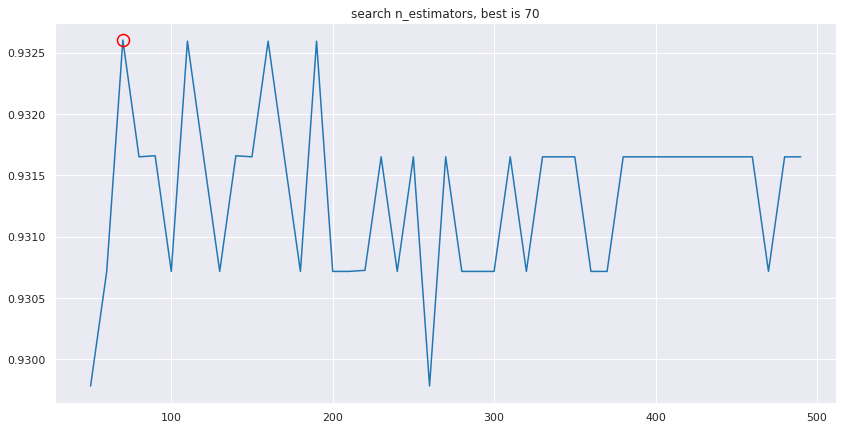

In [21]:
plt.figure(figsize=(14, 7))
param_name = 'n_estimators'
param_range = kl_ml.estimator.grid.param_grid[param_name]
plt.plot(param_range, grid_scores)
plt.plot(kl_ml.estimator.grid.best_params_[param_name], 
         kl_ml.estimator.grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
                 markerfacecolor='None', markeredgecolor='r')
plt.title('search {}, best is {}'.format(param_name, kl_ml.estimator.grid.best_params_[param_name]))
plt.show()

#### 指定参数

In [22]:
param_grid = {'max_features': ['sqrt', 'log2'], 'n_estimators': np.arange(50, 500, 50)}
kl_ml.random_forest_classifier_best(param_grid=param_grid)

start grid search please wait...


RandomForestClassifier(max_features='sqrt', n_estimators=50)

In [23]:
cv_results = kl_ml.estimator.grid.cv_results_
grid_scores = cv_results['mean_test_score']
grid_params = cv_results['params']

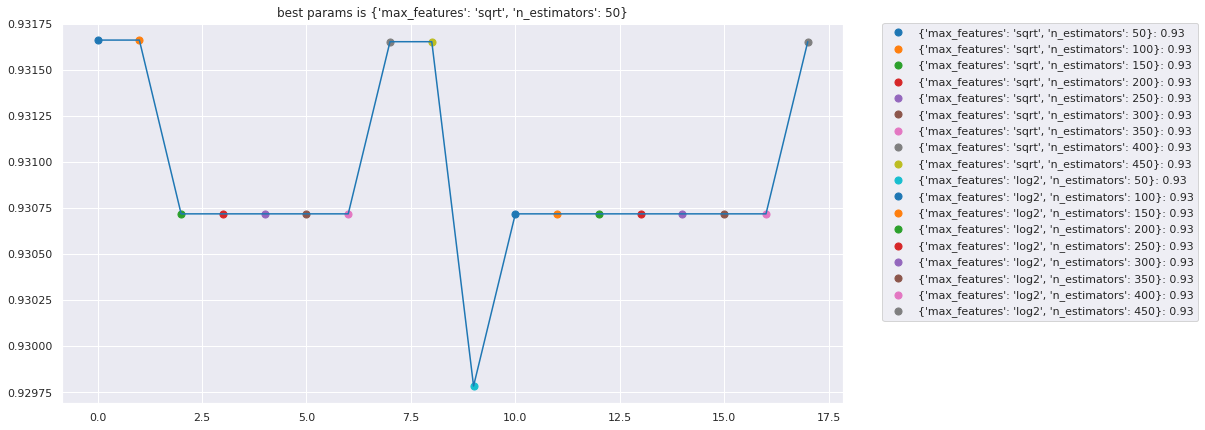

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(grid_scores)
cmap = plt.get_cmap('jet', len(grid_scores))
cmap.set_under('gray')
for grid_index in np.arange(0, len(grid_scores)):
    # 迭代每一个分数，绘制点在曲线上根据分数用颜色区分，使用label进行标注
    plt.scatter(grid_index, grid_scores[grid_index], s=50, cmap=cmap,
                        vmin=np.min(grid_scores),
                        vmax=np.max(grid_scores),
                        label='{}: {:.2f}'.format(grid_params[grid_index], grid_scores[grid_index]))
plt.title('best params is {}'.format(kl_ml.estimator.grid.best_params_))
# 将label标注文字绘制在外面
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### 对训练集进行交叉准确率评分

In [25]:
kl_ml.cross_val_accuracy_score()

2022-10-10 10:31:01,618 - [automodel.py:1522] - ultron - INFO - RandomForestClassifier score mean: 0.9288485275965439


array([0.93457944, 0.92523364, 0.93457944, 0.93457944, 0.92523364,
       0.91588785, 0.92523364, 0.92523364, 0.93396226, 0.93396226])

#### 对训练集进行交叉roc_auc评分：

In [26]:
kl_ml.cross_val_roc_auc_score()

2022-10-10 10:31:03,050 - [automodel.py:1522] - ultron - INFO - RandomForestClassifier score mean: 0.8090984848484849


array([0.73785714, 0.77857143, 0.83642857, 0.86285714, 0.76199495,
       0.83459596, 0.72222222, 0.88257576, 0.88744589, 0.78643579])

In [27]:
kl_ml.cross_val_roc_auc_score(fiter_type=EMLFitType.E_FIT_REG)

2022-10-10 10:31:03,056 - [automodel.py:90] - ultron - INFO - cross_val_roc_auc_score not support reg!


#### 查看训练集输出的precision_score，recall_score，混淆矩阵，以及f1等度量结果：

In [28]:
kl_ml.train_test_split_xy()

x-y:(1068, 42)-(1068,)
train_x-train_y:(961, 42)-(961,)
test_x-test_y:(107, 42)-(107,)
accuracy = 0.93
precision_score = 0.00
recall_score = 0.00
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 100 |   0 |
Actual   |-----|-----|
       1 |   7 |   0 |
         |-----|-----|
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97       100
         1.0       0.00      0.00      0.00         7

    accuracy                           0.93       107
   macro avg       0.47      0.50      0.48       107
weighted avg       0.87      0.93      0.90       107



/home/kerry/work/workenv/ultron/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kerry/work/workenv/ultron/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kerry/work/workenv/ultron/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kerry/work/workenv/

##### 通过feature_selection对特征的支持度进行评级：

In [29]:
pd.options.display.max_rows = 48
kl_ml.feature_selection(show=False).sort_values(by='ranking')

RFE selection
                     support  ranking
one_atr14               True        1
one_atr21               True        1
one_close              False        6
one_high                True        1
one_low                 True        1
one_ma10                True        1
one_ma21                True        1
one_ma5                 True        1
one_ma60                True        1
one_open                True        1
one_pre_close           True        1
one_volume              True        1
today_low               True        1
today_open             False        2
today_pre_close         True        1
two_atr14               True        1
two_atr21               True        1
two_close               True        1
two_high               False        3
two_low                 True        1
two_ma10                True        1
two_ma21               False        5
two_ma5                False        7
two_ma60                True        1
two_open                True        

,support,ranking
one_atr14,True,1
two_pre_close,True,1
two_open,True,1
two_ma60,True,1
two_low,True,1
two_close,True,1
two_atr21,True,1
two_atr14,True,1
today_pre_close,True,1
today_low,True,1


##### 通过importances_coef_pd对特征的重要程度进行量化：

In [30]:
kl_ml.importances_coef_pd().sort_values(by='importance')[::-1]

,feature,importance
1,one_atr21,0.062744
10,one_pre_close,0.052376
16,two_atr21,0.052128
0,one_atr14,0.047310
4,one_low,0.047196
12,today_low,0.046925
15,two_atr14,0.044979
3,one_high,0.039267
19,two_low,0.038775
11,one_volume,0.035802


### 测试集的验证与非均衡技术

In [31]:
kl_test0 = kl_siblings_df(kl_test_raw)
kl_test1 = kl_siblings_df(kl_test_raw[1:])
kl_test2 = kl_siblings_df(kl_test_raw[2:])
kl_test = pd.concat([kl_test0, kl_test1, kl_test2])
kl_test.index = np.arange(0, kl_test.shape[0])
dummies_one_week = pd.get_dummies(kl_test['one_date_week'], prefix='one_date_week')
dummies_two_week = pd.get_dummies(kl_test['two_date_week'], prefix='two_date_week')
dummies_today_week = pd.get_dummies(kl_test['today_date_week'], prefix='today_date_week')
kl_test.drop(['one_date_week', 'two_date_week', 'today_date_week'], inplace=True, axis=1)
kl_test = pd.concat([kl_test, dummies_one_week, dummies_two_week, dummies_today_week], axis=1)
matrix_test = kl_test.values
y_test = matrix_test[:, 0]
x_test = matrix_test[:, 1:]

对测试集数据进行准确率评估，代码如下所示：

In [32]:
from sklearn import metrics
y_predict = [kl_ml.predict(x_test[test_ind])[0] for test_ind in np.arange(0, matrix_test.shape[0])]
print('测试集正确率{:3f}'.format(metrics.accuracy_score(y_test, y_predict)))

测试集正确率0.948276


上面的准确率结果为96%以上正确，下面使用predict_proba看看概率结果

In [33]:
y_prob = [kl_ml.predict_proba(x_test[test_ind])[0] for test_ind in np.arange(0, matrix_test.shape[0])]

In [34]:
y_prob[-10:]

[array([0.9, 0.1]),
 array([0.96, 0.04]),
 array([0.96, 0.04]),
 array([0.88, 0.12]),
 array([0.98, 0.02]),
 array([0.98, 0.02]),
 array([0.96, 0.04]),
 array([0.74, 0.26]),
 array([1., 0.]),
 array([0.88, 0.12])]

上面predict的决策在某一个值在0.85以上即进行了判断，如果我们希望把握更大一些就需要调整这个值，比如0.9以上才能认定决策，那首要的问题就是如何选定这个阀值，使用search_match_pos_threshold进行阀值的确定：

In [35]:
kl_ml.search_match_pos_threshold(accuracy_match=0.9)

2022-10-10 10:31:26,664 - [automodel.py:455] - ultron - INFO - threshold=0.5 prob accuracy=0.93, effect cnt=1068, effect rate=1.00, score=0.93
2022-10-10 10:31:26,664 - [automodel.py:1084] - ultron - INFO - 0.500 satisfy require, accuracy:0.934, effect_rate:1.000


0.5

下面使用0.5做为阀值，通过predict_proba_threshold函数进行决策，代码如下：

In [36]:
y_prob_threshold = [kl_ml.predict_proba_threshold(x_test[test_ind], 0.5, 0)
                    for test_ind in np.arange(0, matrix_test.shape[0])]

上面predict_proba_threshold传递的第三个参数0为未达成有效决策的情况下返回的决策结果，即阀值二分化后结果为(0, 0)后这里返回0，因为在比特币这个示例中如果交易者想要保守的方式决策今天是否适合做日内交易，那么就希望只在有很大概率的情况下返回1，即适合交易，其它情况下没有太大把握下全部返回0即可，下面使用precision_score计算查准率

In [37]:
metrics.precision_score(y_test, y_prob_threshold)

1.0

查准率100%正确，但召回率评分非常低，即螺纹钢在很多有大行情的情况下为了保守，放弃了日交易，只在把握大的时候行动:

In [38]:
metrics.recall_score(y_test, y_prob_threshold)

0.3333333333333333

与上面的情况相反也有些激进的交易者想要的决策结果是只要今天不是很大把握说没有行情，那就进行交易。

下面使用0.90做为阀值，通过predict_proba_threshold函数进行决策，第三个参数1即在为未达成有效决策的情况下返回的决策结果为1，可以看到结果的决策中大多数都被决策为1，代码如下：

In [39]:
y_prob_threshold = [kl_ml.predict_proba_threshold(x_test[test_ind], 0.90, 1)
                    for test_ind in np.arange(0, matrix_test.shape[0])]
pd.Series(y_prob_threshold).value_counts()

0    37
1    21
dtype: int64